In [2]:
import os
from PIL import Image
import seaborn as sns
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
#drive.mount('/content/drive')

import os
from PIL import Image
import pandas as pd

folder1_path = r'C:\Users\Asus\Music\MachineLearning\signatures\full_forg'
folder2_path = r'C:\Users\Asus\Music\MachineLearning\signatures\full_org'

data = []

def process_folder(folder_path, label):
    target_size = (128,128)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.png'):
            file_path = os.path.join(folder_path, file_name)
            try:
                with Image.open(file_path) as img:
                    img = img.convert('L')  # Convert to grayscale
                    img = img.resize(target_size)  # Resize image
                    img_data = list(img.getdata())  # Convert image to list of pixel values
                    data.append({'file_path': file_path, 'image_data': img_data, 'label': label})
            except Exception as e:
                print(f"Error processing image {file_name}: {e}")

process_folder(folder1_path, label='Forgery')
process_folder(folder2_path, label='Original')

df = pd.DataFrame(data)

print(df.head())
data = []

def process_folder(folder_path, label):
    target_size = (128,128)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.png'):
            file_path = os.path.join(folder_path, file_name)
            with Image.open(file_path) as img:
                img = img.convert('L')  # Convert to grayscale
                img = img.resize(target_size)  # Resize image
                img_data = list(img.getdata())  # Convert image to list of pixel values
                data.append({'file_path': file_path, 'image_data': img_data, 'label': label})

process_folder(folder1_path, label='Forgery')
process_folder(folder2_path, label='Original')

df = pd.DataFrame(data)

print(df.head())

                                           file_path  \
0  C:\Users\Asus\Music\MachineLearning\signatures...   
1  C:\Users\Asus\Music\MachineLearning\signatures...   
2  C:\Users\Asus\Music\MachineLearning\signatures...   
3  C:\Users\Asus\Music\MachineLearning\signatures...   
4  C:\Users\Asus\Music\MachineLearning\signatures...   

                                          image_data    label  
0  [255, 255, 255, 255, 255, 255, 255, 255, 255, ...  Forgery  
1  [255, 255, 255, 255, 255, 255, 255, 255, 255, ...  Forgery  
2  [255, 255, 255, 255, 255, 255, 255, 255, 255, ...  Forgery  
3  [255, 255, 255, 255, 255, 255, 255, 255, 255, ...  Forgery  
4  [255, 255, 254, 255, 255, 255, 255, 255, 255, ...  Forgery  
                                           file_path  \
0  C:\Users\Asus\Music\MachineLearning\signatures...   
1  C:\Users\Asus\Music\MachineLearning\signatures...   
2  C:\Users\Asus\Music\MachineLearning\signatures...   
3  C:\Users\Asus\Music\MachineLearning\signatures...   

In [4]:
print(df.shape)

(2640, 3)


#**Feature Selection:**

**Hu Moments:**
Captures geometric shape properties — helpful for distinguishing overall shape and curves of signatures.

**HOG (Histogram of Oriented Gradients):**
 Describes local edge orientations and texture patterns — useful for identifying handwriting patterns.

**Pixel Density:**
 Measures the proportion of inked pixels — good for detecting how heavy or light the signature is.


In [5]:
def extract_hu_moments(image):
    moments = cv2.moments(image)
    hu_moments = cv2.HuMoments(moments).flatten()
    return np.log(np.abs(hu_moments) + 1e-5)

In [6]:
def extract_hog(image):
    features, _ = hog(image, orientations = 9, pixels_per_cell= (8,8),
                      cells_per_block= (2,2), visualize = True, block_norm ='L2-Hys')
    return features

In [7]:
def extract_pixel_density(image):
    return np.sum(image == 0)/image.size

In [8]:
def extract_all_features(df):
    features = []
    for img_data in df['image_data']:
        img = np.array(img_data, dtype=np.uint8).reshape((128, 128))
        hu_moments = extract_hu_moments(img)
        hog_features = extract_hog(img)
        pixel_density = extract_pixel_density(img)
        feature_vector = np.concatenate([hu_moments, hog_features, [pixel_density]])
        features.append(feature_vector)
    return np.array(features)


Labeling mapping

In [9]:
#df['label'] = df['label'].map({'Forgery': 1, 'Original': 0})

In [10]:
X = extract_all_features(df)
y = df['label'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

After using grid search to finetune the hyperparameters, I have deployed the best performing model with their respective parametrs

{'ccp_alpha': 0.001, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}
Accuracy: 0.9621212121212122
              precision    recall  f1-score   support

     Forgery       0.95      0.97      0.96       260
    Original       0.97      0.96      0.96       268

    accuracy                           0.96       528
   macro avg       0.96      0.96      0.96       528
weighted avg       0.96      0.96      0.96       528



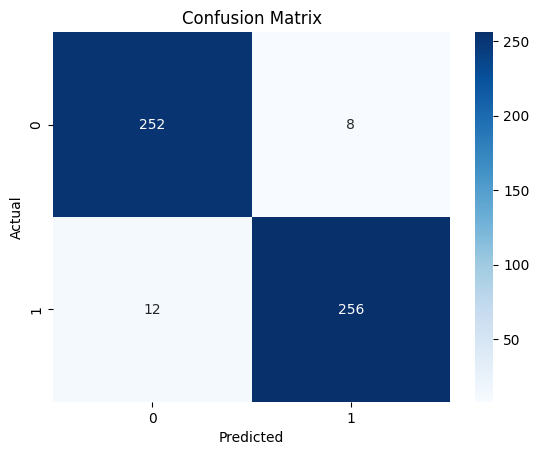

In [11]:
param_grid = {
    'max_depth': [10],
    'ccp_alpha': [0.001],
    'criterion': ['entropy']
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best Model
clf = grid_search.best_estimator_
print(clf.get_params())
clf.fit(X_train, y_train)

# Evaluation
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#**NST Pipeline**

In [12]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.optimizers import Adam
import pickle

# Importing the pickle (binary) file

In [13]:
def unpickle(file):
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
    return data_dict


In [15]:
batch_files = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']

# Folder to save resized images
os.makedirs("artbench_styles", exist_ok=True)

/artbench_styles

In [16]:
import random
from PIL import Image

selected_images = []

for batch in batch_files:
    file_source = os.path.join(r'C:\Users\Asus\Music\MachineLearning\signatures\artbench-10-python\artbench-10-batches-py', batch)
    data = unpickle(file_source)
    images = data['data']
    labels = data['labels']

    # Reshape the data into 32x32x3 images (original dataset resolution)
    images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    random_indices = random.sample(range(len(images)), 2)
    for idx in random_indices:
        img = images[idx]
        selected_images.append(img)

        # Convert to PIL image and resize to 128x128
        img_pil = Image.fromarray(img)
        img_resized = img_pil.resize((128, 128), Image.Resampling.LANCZOS)

        # Save Image
        img_resized.save(f"artbench_styles/style_{len(selected_images)}.png")
    labels = data['labels']

    # Reshape the data into 32x32x3 images (original dataset resolution)
    images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    random_indices = random.sample(range(len(images)), 2)
    for idx in random_indices:
        img = images[idx]
        selected_images.append(img)

            # Convert to PIL image and resize to 128x128
        img_pil = Image.fromarray(img)
        img_resized = img_pil.resize((128, 128), Image.Resampling.LANCZOS)

            # Save Image
        img_resized.save(f"artbench_styles/style_{len(selected_images)}.png")

Importing modules for NST blending and feature extraction

In [17]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import torchvision.transforms.functional as TF

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

This pipeline applies resizing, conversion to tensor, and unsqueezing to prepare the image for model input

In [19]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.unsqueeze(0))
])

Loads the pretrained VGG-19 model, transfers it to the selected device, and sets it to evaluation mode.

In [20]:
vgg = models.vgg19(pretrained=True).features.to(device).eval()

C:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
style_layers = [0, 5, 10, 19, 28]
content_layers = [21]


In [22]:
print("Style Layers:", style_layers)
print("Content Layers:", content_layers)

Style Layers: [0, 5, 10, 19, 28]
Content Layers: [21]


In [ ]:
print(vgg)

Defines a function to extract feature maps from specified layers of the VGG model.

In [23]:
def extract_features(image, model, layers):
    features = []
    x = image.to(device)
    for i, layer in enumerate(model):
        x = layer(x)
        if i in layers:
            features.append(x)
    return features

Calculates the Gram matrix, which captures texture information from feature maps for style representation.

In [24]:
def gram_matrix(tensor):
    _, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram / (c * h * w)

In [25]:
def gram_matrix(tensor):
    B, C, H, W = tensor.size()
    tensor = tensor.view(B, C, H * W)
    gram = torch.bmm(tensor, tensor.transpose(1, 2))
    return gram / (C * H * W)

In [26]:
def tv_loss(img):
    x_var = torch.mean((img[:, :, 1:, :] - img[:, :, :-1, :]) ** 2)
    y_var = torch.mean((img[:, :, :, 1:] - img[:, :, :, :-1]) ** 2)
    return (x_var + y_var)

Performs the style transfer optimization by minimizing content and style losses using the Adam optimizer.

In [27]:
def neural_style_transfer(content_img, style_img, num_steps=300, alpha=1e5, beta=1e7, tv_weight=1e-6):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Utilize GPU if available
    torch.backends.cudnn.benchmark = True
    torch.cuda.empty_cache()
    content = transform(content_img).to(device)
    style = transform(style_img.resize(content_img.size)).to(device)  # Resize style image to match content size
    generated = content.clone().requires_grad_(True).to(device)
    optimizer = torch.optim.Adam([generated], lr=0.01)

    style_features = extract_features(style, vgg.to(device), style_layers)  # Move model to device
    content_features = extract_features(content, vgg, content_layers)
    style_grams = [gram_matrix(f) for f in style_features]

    initial_beta = beta

    for step in range(num_steps):
        optimizer.zero_grad()


        layers = style_layers + content_layers
        generated_features = extract_features(generated, vgg, layers) # Pass the merged list of layers
        print(f"Length of generated_features: {len(generated_features)}")

        generated_content = generated_features[-1]  # Get the last feature map for content loss


        content_features_resized = torch.nn.functional.interpolate(
            content_features[0], size=generated_content.shape[-2:], mode='bilinear', align_corners=False
        ).to(device)
        content_loss = torch.mean((generated_content - content_features_resized) ** 2)

        style_loss = 0
        for gf, sg in zip(generated_features[:len(style_layers)], style_grams):
            gm = gram_matrix(gf)
            style_loss += torch.mean((gm - sg) ** 2)
        style_loss /= len(style_layers)  # Normalize style loss

        total_variation = tv_loss(generated)

        total_loss = alpha * content_loss + beta * style_loss + 1e-6 * tv_loss(generated)
        total_loss.backward(retain_graph=True)
        optimizer.step()

        # Annealing style weight
        beta = initial_beta * (0.995 ** step)

        if step % 50 == 0:
            print(f"Step {step}/{num_steps}, Content Loss: {content_loss.item()}, Style Loss: {style_loss.item()}, Total Loss: {total_loss.item()}")

    forged = TF.to_pil_image(generated.squeeze(0).cpu().detach()).convert('L')  # Convert NST output to grayscale
    return forged



In [28]:
def generate_nst_forgeries(signature_dir, style_dir, output_dir):
    signature_files = os.listdir(signature_dir)
    style_files = os.listdir(style_dir)
    os.makedirs(output_dir, exist_ok=True)

    for i, signature_file in enumerate(signature_files):
        signature_path = os.path.join(signature_dir, signature_file)
        style_path = os.path.join(style_dir, style_files[i % len(style_files)])
        content_img = Image.open(signature_path).convert("RGB")
        style_img = Image.open(style_path).convert("RGB")
        forgery = neural_style_transfer(content_img, style_img)
        forgery.save(f"{output_dir}/{signature_file.replace('.png', '_nst.png')}")

In [29]:
def generate_nst_forgeries(signature_dir, style_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for signature_file in os.listdir(signature_dir):
        if signature_file.endswith('.png'):
            signature_path = os.path.join(signature_dir, signature_file)

            for style_file in os.listdir(style_dir):
                if style_file.endswith('.jpg') or style_file.endswith('.png'):
                    style_path = os.path.join(style_dir, style_file)

                    content_img = Image.open(signature_path).convert("RGB")
                    style_img = Image.open(style_path).convert("L").convert("RGB")  # Fix here 🔥

                    forgery = neural_style_transfer(content_img, style_img)
                    forgery.save(f"{output_dir}/{signature_file.replace('.png', '')}_{style_file}_NST.png")
                    print(f"Generated: {signature_file} + {style_file}")


In [ ]:
print(tf.test.gpu_device_name())

In [ ]:
!nvidia-smi

In [30]:
#generate_nst_forgeries(r'C:\Users\Asus\Music\MachineLearning\signatures\full_forg',r'C:\Users\Asus\artbench_styles','nst_forg')

Streaming output truncated to the last 5000 lines.
Length of generated_features: 6
Length of generated_features: 6
Length of generated_features: 6
Length of generated_features: 6
Length of generated_features: 6
Length of generated_features: 6
Length of generated_features: 6
Length of generated_features: 6
Length of generated_features: 6
Length of generated_features: 6
Length of generated_features: 6
Length of generated_features: 6
Length of generated_features: 6
Length of generated_features: 6
Length of generated_features: 6
Step 100/300, Content Loss: 3.628486394882202, Style Loss: 8.912375960790087e-06, Total Loss: 362902.875
Length of generated_features: 6
Length of generated_features: 6
Length of generated_features: 6
Length of generated_features: 6
Length of generated_features: 6
Length of generated_features: 6
Length of generated_features: 6
Length of generated_features: 6
Length of generated_features: 6
Length of generated_features: 6
Length of generated_features: 6
Length of ge

KeyboardInterrupt: 

Generating NST forged signatures requires a lot of computational power and time. So I've created a folder of NST forged signatures from using the above functions to generate and used it to retrain and evaluate my Decision Tree Model. If the user wants to generate their own set of generated images, use the above functions to generate one or they can use the nst_forg folder I've attached along with the notebook

In [31]:
folder1_path = r'C:\Users\Asus\Music\MachineLearning\signatures\full_forg'
folder2_path = r'C:\Users\Asus\Music\MachineLearning\signatures\full_org'
folder3_path = r'C:\Users\Asus\nst_forg'

data = []

def process_folder(folder_path, label):
    target_size = (128,128)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.png'):
            file_path = os.path.join(folder_path, file_name)
            with Image.open(file_path) as img:
                img = img.convert('L')  # Convert to grayscale
                img = img.resize(target_size)  # Resize image
                img_data = list(img.getdata())  # Convert image to list of pixel values
                data.append({'file_path': file_path, 'image_data': img_data, 'label': label})

process_folder(folder1_path, label='Forgery')
process_folder(folder2_path, label='Original')
process_folder(folder3_path, label='NST_forged')

df = pd.DataFrame(data)

print(df.head())

                                           file_path  \
0  C:\Users\Asus\Music\MachineLearning\signatures...   
1  C:\Users\Asus\Music\MachineLearning\signatures...   
2  C:\Users\Asus\Music\MachineLearning\signatures...   
3  C:\Users\Asus\Music\MachineLearning\signatures...   
4  C:\Users\Asus\Music\MachineLearning\signatures...   

                                          image_data    label  
0  [255, 255, 255, 255, 255, 255, 255, 255, 255, ...  Forgery  
1  [255, 255, 255, 255, 255, 255, 255, 255, 255, ...  Forgery  
2  [255, 255, 255, 255, 255, 255, 255, 255, 255, ...  Forgery  
3  [255, 255, 255, 255, 255, 255, 255, 255, 255, ...  Forgery  
4  [255, 255, 254, 255, 255, 255, 255, 255, 255, ...  Forgery  


In [32]:
X = extract_all_features(df)
y = df['label'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [5],
    'criterion': ['entropy'],
    'ccp_alpha': [0.2]
}

clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy')
clf.fit(X_train, y_train)

print("Best Parameters:", clf.best_params_)
print("Best Accuracy:", clf.best_score_)


Best Parameters: {'ccp_alpha': 0.2, 'criterion': 'entropy', 'max_depth': 5}
Best Accuracy: 0.9725427462237306


In [34]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf.best_estimator_.predict(X_test)

print("Classification Report")
print(classification_report(y_test, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))


Classification Report
              precision    recall  f1-score   support

     Forgery       0.99      0.91      0.95       281
  NST_forged       1.00      1.00      1.00       244
    Original       0.91      0.99      0.95       268

    accuracy                           0.96       793
   macro avg       0.97      0.97      0.96       793
weighted avg       0.97      0.96      0.96       793

Confusion Matrix
[[255   0  26]
 [  0 244   0]
 [  3   0 265]]


In [44]:
nst_forgery_df['label'] = nst_forgery_df['label'].replace('NST_forged', 'Forged')
nst_forgery_df = df[df['label'].isin(['Forged', 'Original'])]

X_nst = extract_all_features(nst_forgery_df)
X_nst = scaler.transform(X_nst)

y_nst = nst_forgery_df['label'].values
y_pred_nst = clf.best_estimator_.predict(X_nst)

print("NST Forgery Detection Results")
print(classification_report(y_nst, y_pred_nst))


C:\Users\Asus\AppData\Local\Temp\ipykernel_13696\1624779659.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nst_forgery_df['label'] = nst_forgery_df['label'].replace('NST_forged', 'Forged')


NST Forgery Detection Results
              precision    recall  f1-score   support

     Forgery       0.00      0.00      0.00         0
    Original       1.00      1.00      1.00      1320

    accuracy                           1.00      1320
   macro avg       0.50      0.50      0.50      1320
weighted avg       1.00      1.00      1.00      1320



C:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [45]:
nst_forgery_df['label'].value_counts()


label
Original    1320
Name: count, dtype: int64

In [46]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf.best_estimator_.predict(X_test)

print("Classification Report")
print(classification_report(y_test, y_pred, zero_division=1)) #Added zero_division=1

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))


nst_forgery_df = df[df['label'] == 'NST_forged']
X_nst = extract_all_features(nst_forgery_df)
X_nst = scaler.transform(X_nst)

y_nst = nst_forgery_df['label'].values
y_pred_nst = clf.best_estimator_.predict(X_nst)

print("NST Forgery Detection Results")
print(classification_report(y_nst, y_pred_nst, zero_division=1)) #Added zero_division=1

Classification Report
              precision    recall  f1-score   support

     Forgery       0.99      0.91      0.95       281
  NST_forged       1.00      1.00      1.00       244
    Original       0.91      0.99      0.95       268

    accuracy                           0.96       793
   macro avg       0.97      0.97      0.96       793
weighted avg       0.97      0.96      0.96       793

Confusion Matrix
[[255   0  26]
 [  0 244   0]
 [  3   0 265]]
NST Forgery Detection Results
              precision    recall  f1-score   support

  NST_forged       1.00      1.00      1.00      1321

    accuracy                           1.00      1321
   macro avg       1.00      1.00      1.00      1321
weighted avg       1.00      1.00      1.00      1321

